# Predicción del Precio de Vehículos: Un Enfoque con Regresión Lineal y Regularización

Este análisis tiene como objetivo principal desarrollar un modelo de regresión lineal robusto capaz de **predecir el valor de un vehículo** basándose en un conjunto de características clave, para lograrlo abordaremos el problema siguiendo una metodología estructurada que incluye:

1.  **Exploración Inicial del Conjunto de Datos:** Realizaremos un análisis del conjunto de datos para comprender la distribución de las variables, identificar posibles valores atípicos y detectar relaciones preliminares entre las características y el precio del vehículo. 

2.  **Construcción del Modelo de Regresión Lineal Base:** Desarrollaremos un modelo de regresión lineal inicial utilizando las características seleccionadas. Este modelo servirá como punto de partida para nuestras predicciones.

3.  **Evaluación de la Bondad de Ajuste del Modelo:** Mediremos la calidad de nuestro modelo a través de diversas métricas de evaluación, como el $R^2$, el error cuadrático medio (MSE) y el error absoluto medio (MAE). Estas métricas nos permitirán cuantificar la precisión de las predicciones del modelo.

4.  **Aplicación de Términos Polinomiales:** Para capturar relaciones no lineales entre las características y el precio, incorporaremos términos polinomiales al conjunto de características, esto puede mejorar la capacidad del modelo para ajustarse a patrones más complejos en los datos.

5.  **Optimización del Modelo con Regularización Lasso:** Finalmente, aplicaremos la técnica de regularización Lasso (Least Absolute Shrinkage and Selection Operator). Esta técnica no solo ayuda a prevenir el sobreajuste al penalizar los coeficientes de las características, sino que también realiza una selección de características automática, identificando aquellas que tienen una mayor influencia en la predicción del precio del vehículo.

A través de este enfoque sistemático, buscamos construir un modelo predictivo preciso y interpretable, que pueda ser una herramienta valiosa para estimar el precio de los vehículos.


## Librerías 

In [53]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Exploración de datos faltantes
import missingno as msng


# Regresión Lineal
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LassoCV, Lasso


#Configuración Gráficas y tablas
# ==============================================================================
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [6, 4.5]
palette = ["#003049","#d62828","#f77f00","#fcbf49","#eae2b7"]
sns.set_theme( palette= palette, context= "notebook")
pd.options.display.float_format = '{:.2f}'.format


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Ingesta de Datos

Para dar inicio a nuestro análisis, el primer paso es ingresar el DataFrame que contiene toda la información de los vehículos. Este DataFrame será la base sobre la cual realizaremos nuestra exploración inicial y, posteriormente, implementaremos los diferentes modelos de regresión.

In [54]:
# Ingresamos el conjunto de datos y lo asignamos a "df"
# ==============================================================================
df = pd.read_csv("car data.csv")
df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


## Eliminación de la Variable Car_Name

Procederemos a eliminar la característica Car_Name de nuestro DataFrame. La razón detrás de esta decisión es que, si bien el nombre del vehículo es una identificación, no nos aporta información útil directamente para la predicción de su precio en el contexto de un modelo de regresión lineal. Es una variable categórica con una alta cardinalidad (muchos valores únicos), lo que dificultaría su manejo y no ofrecería un valor predictivo significativo para nuestro objetivo.

In [55]:
# Eliminamos la caracteristica "Car_Name"
# ==============================================================================
df.drop(columns="Car_Name", inplace= True)
df

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...
296,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


### Modificamos los valores de Year por la antiguedad
A continuación, vamos a transformar la variable Year que corresponde al año de fabricación del vehículo en una nueva característica que denominaremos Age. Esta transformación es crucial porque la antigüedad del vehículo ya que es una medida más directa y significativa para predecir su precio que el año de fabricación en sí mismo. Al hacer esta transformación, nuestro modelo podrá capturar de mejor manera cómo el paso del tiempo y el uso impactan en el valor del vehículo.

In [56]:
# Añadimos la columna Age con la transformación
# ==============================================================================
maximo = df["Year"].max()
antiguedad = df["Year"].apply(lambda x: maximo - x +1)
df["Age"] = antiguedad

# Eliminamos la columna Year
# ==============================================================================
df.drop(columns="Year", inplace= True)
df

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,5
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,6
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,2
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,8
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,5
...,...,...,...,...,...,...,...,...
296,9.50,11.60,33988,Diesel,Dealer,Manual,0,3
297,4.00,5.90,60000,Petrol,Dealer,Manual,0,4
298,3.35,11.00,87934,Petrol,Dealer,Manual,0,10
299,11.50,12.50,9000,Diesel,Dealer,Manual,0,2


## Detección de Valores Faltantes
Para asegurar la integridad y calidad de nuestro análisis, es fundamental verificar si el conjunto de datos contiene valores faltantes, esto nos permitirá identificar cualquier ausencia de información que pueda afectar la precisión de nuestros modelos.

In [57]:
# Hallamos el numero de valores faltantes
# ==============================================================================
df.isna().sum()

Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
Age              0
dtype: int64

### Validacion de datos, formato

In [58]:
# Comprobamos el tipo de datos de cada una de las variables en el conjunto de datos
# ==============================================================================
df.dtypes

Selling_Price    float64
Present_Price    float64
Kms_Driven         int64
Fuel_Type         object
Seller_Type       object
Transmission      object
Owner              int64
Age                int64
dtype: object

In [59]:
# Obtenemos los principales estadísticos descriptivos de las variables Numéricas
# ==============================================================================
df.describe(include= [np.number])

,Selling_Price,Present_Price,Kms_Driven,Owner,Age
count,301.00,301.00,301.00,301.00,301.00
mean,4.66,7.63,36947.21,0.04,5.37
std,5.08,8.64,38886.88,0.25,2.89
min,0.10,0.32,500.00,0.00,1.00
25%,0.90,1.20,15000.00,0.00,3.00
50%,3.60,6.40,32000.00,0.00,5.00
75%,6.00,9.90,48767.00,0.00,7.00
max,35.00,92.60,500000.00,3.00,16.00


In [60]:
# Obtenemos los principales estadísticos descriptivos de las variables Categóricas
# ==============================================================================
df.describe(include= "object")

,Fuel_Type,Seller_Type,Transmission
count,301,301,301
unique,3,2,2
top,Petrol,Dealer,Manual
freq,239,195,261


## Detección de Registros Duplicados
A continuación, verificaremos si el conjunto de datos contiene registros duplicados, la presencia de registros duplicados podría sesgar el modelo de regresión que vamos a implementar, afectando la precisión y fiabilidad de nuestras predicciones.

In [61]:
# Comprobamos si tenemos registros duplicados en el conjunto de datos
# ==============================================================================
df[df.duplicated()]

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
17,7.75,10.79,43000,Diesel,Dealer,Manual,0,3
93,23.00,30.61,40000,Diesel,Dealer,Automatic,0,4


Se han identificado dos registros duplicados en el conjunto de datos. Para evitar que estos registros sesguen nuestro modelo de regresión y asegurar la integridad de nuestro análisis, procederemos a eliminarlos del DataFrame.

In [62]:
# Eliminamos los Duplicados del Conjunto de datos
# ==============================================================================
df.drop_duplicates(inplace= True)
df

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,5
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,6
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,2
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,8
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,5
...,...,...,...,...,...,...,...,...
296,9.50,11.60,33988,Diesel,Dealer,Manual,0,3
297,4.00,5.90,60000,Petrol,Dealer,Manual,0,4
298,3.35,11.00,87934,Petrol,Dealer,Manual,0,10
299,11.50,12.50,9000,Diesel,Dealer,Manual,0,2


### Detección de Valores Atípicos
Para identificar la presencia de valores atípicos extremos en nuestro conjunto de datos, utilizaremos diagramas de caja, esta representacion nos permite resaltar la distribución de los datos y cualquier valor que se desvíe significativamente del resto. Realizaremos este análisis específicamente sobre las variables numéricas de nuestro DataFrame, ya que son las que más pueden influir en el rendimiento de nuestro modelo de regresión.

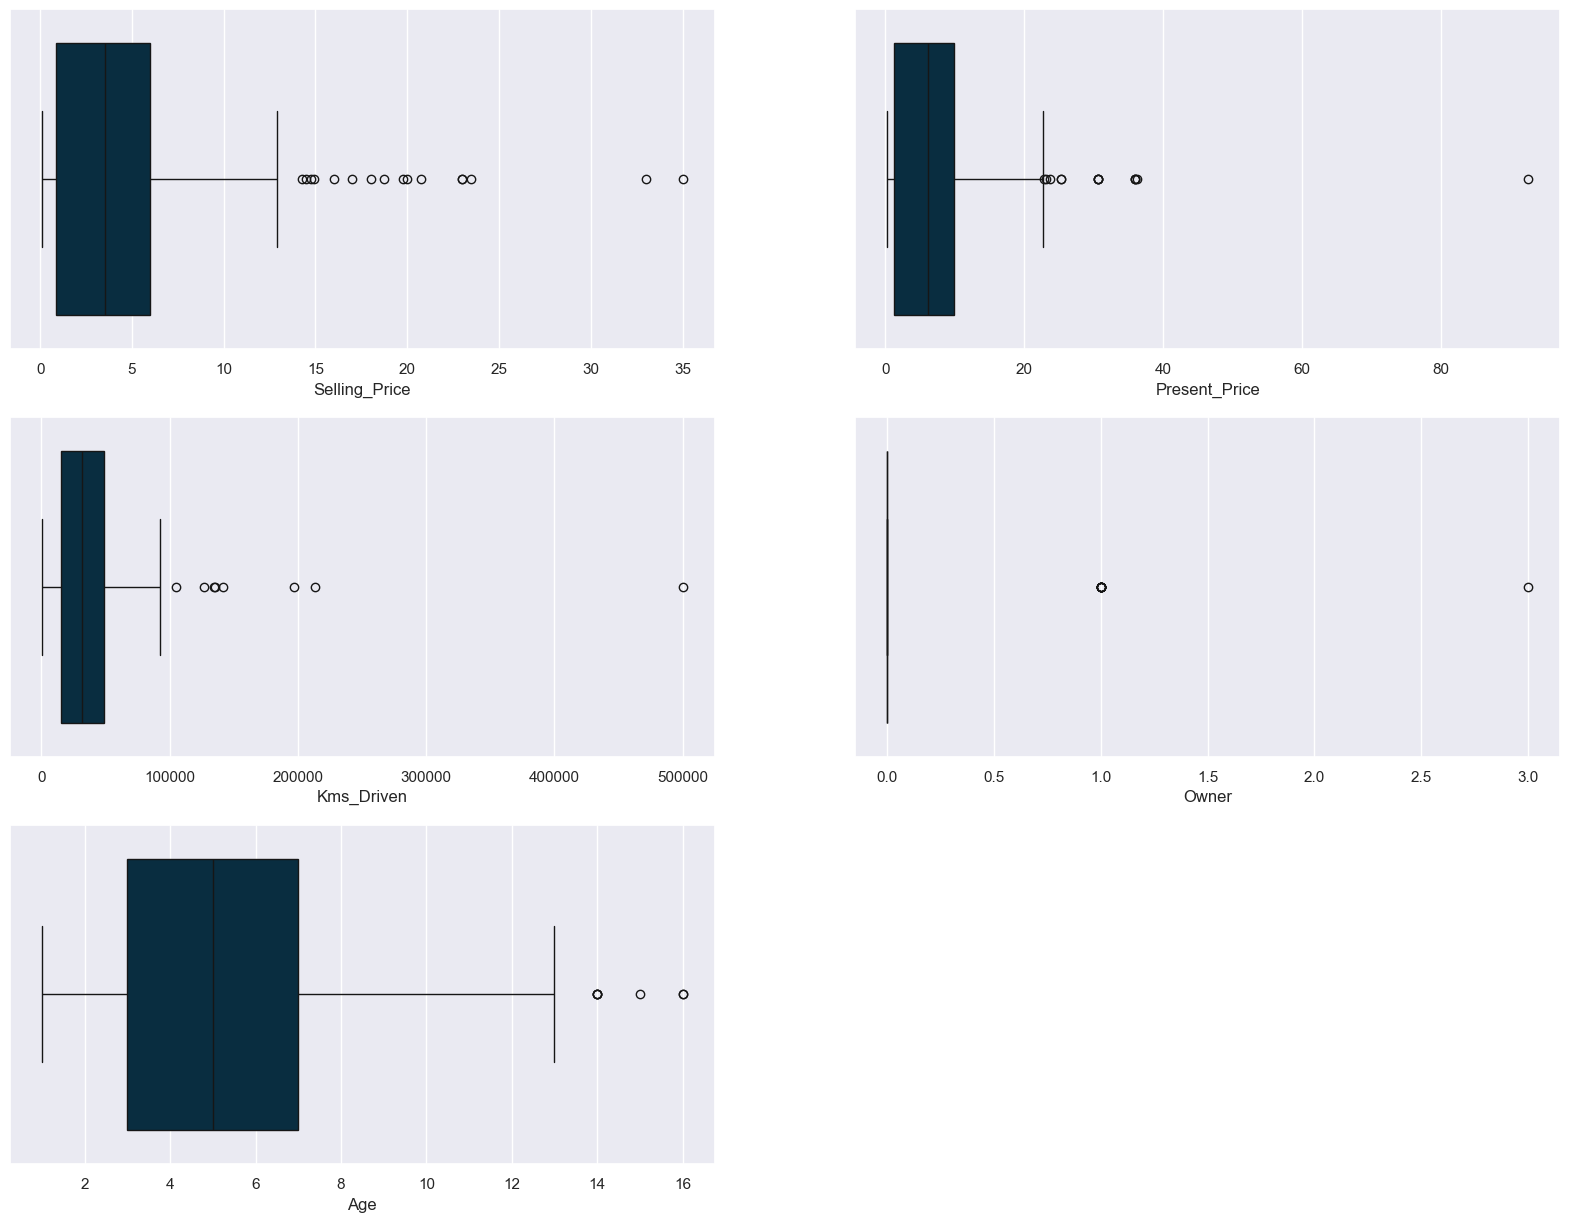

In [63]:
# Mostramos valores atípicos sobre las variables numéricas
# ==============================================================================
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

for i, var in enumerate(df.select_dtypes(include=[np.number])):
    sns.boxplot(data= df,
                x = var,
                ax= axes[i // 2, i % 2]
    )
fig.delaxes(ax= axes[2,1])

In [64]:
# Analizamos los registros que se encuentran mas a los extremos de los diagramas de caja generados
# ==============================================================================
df[(df["Selling_Price"] > 30) | (df["Kms_Driven"] > 400000)]

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
64,33.00,36.23,6000,Diesel,Dealer,Automatic,0,2
86,35.00,92.60,78000,Diesel,Dealer,Manual,0,9
196,0.17,0.52,500000,Petrol,Individual,Automatic,0,11


Hemos identificado tres registros en el conjunto de datos que se encuentran en los extremos de los diagramas de caja. Específicamente, se trata de:

- Los dos vehículos con un precio superior a 30 
- El vehículo con un kilometraje de 500,000.
 
Estos valores extremos tienen el potencial de sesgar nuestro modelo de regresión, lo que resultaría en una disminución de su capacidad de generalización a nuevos datos. Dado que son solo tres registros, su eliminación no afectará negativamente la cantidad de datos disponibles para el entrenamiento del modelo. Por estas razones, procederemos a eliminar estos tres registros atípicos del conjunto de datos.

In [65]:
# Eliminamos los tres registros extremos
# ==============================================================================
df.drop(index= df[(df["Selling_Price"] > 30) | (df["Kms_Driven"] > 400000)].index, inplace= True)
df 

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,5
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,6
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,2
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,8
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,5
...,...,...,...,...,...,...,...,...
296,9.50,11.60,33988,Diesel,Dealer,Manual,0,3
297,4.00,5.90,60000,Petrol,Dealer,Manual,0,4
298,3.35,11.00,87934,Petrol,Dealer,Manual,0,10
299,11.50,12.50,9000,Diesel,Dealer,Manual,0,2


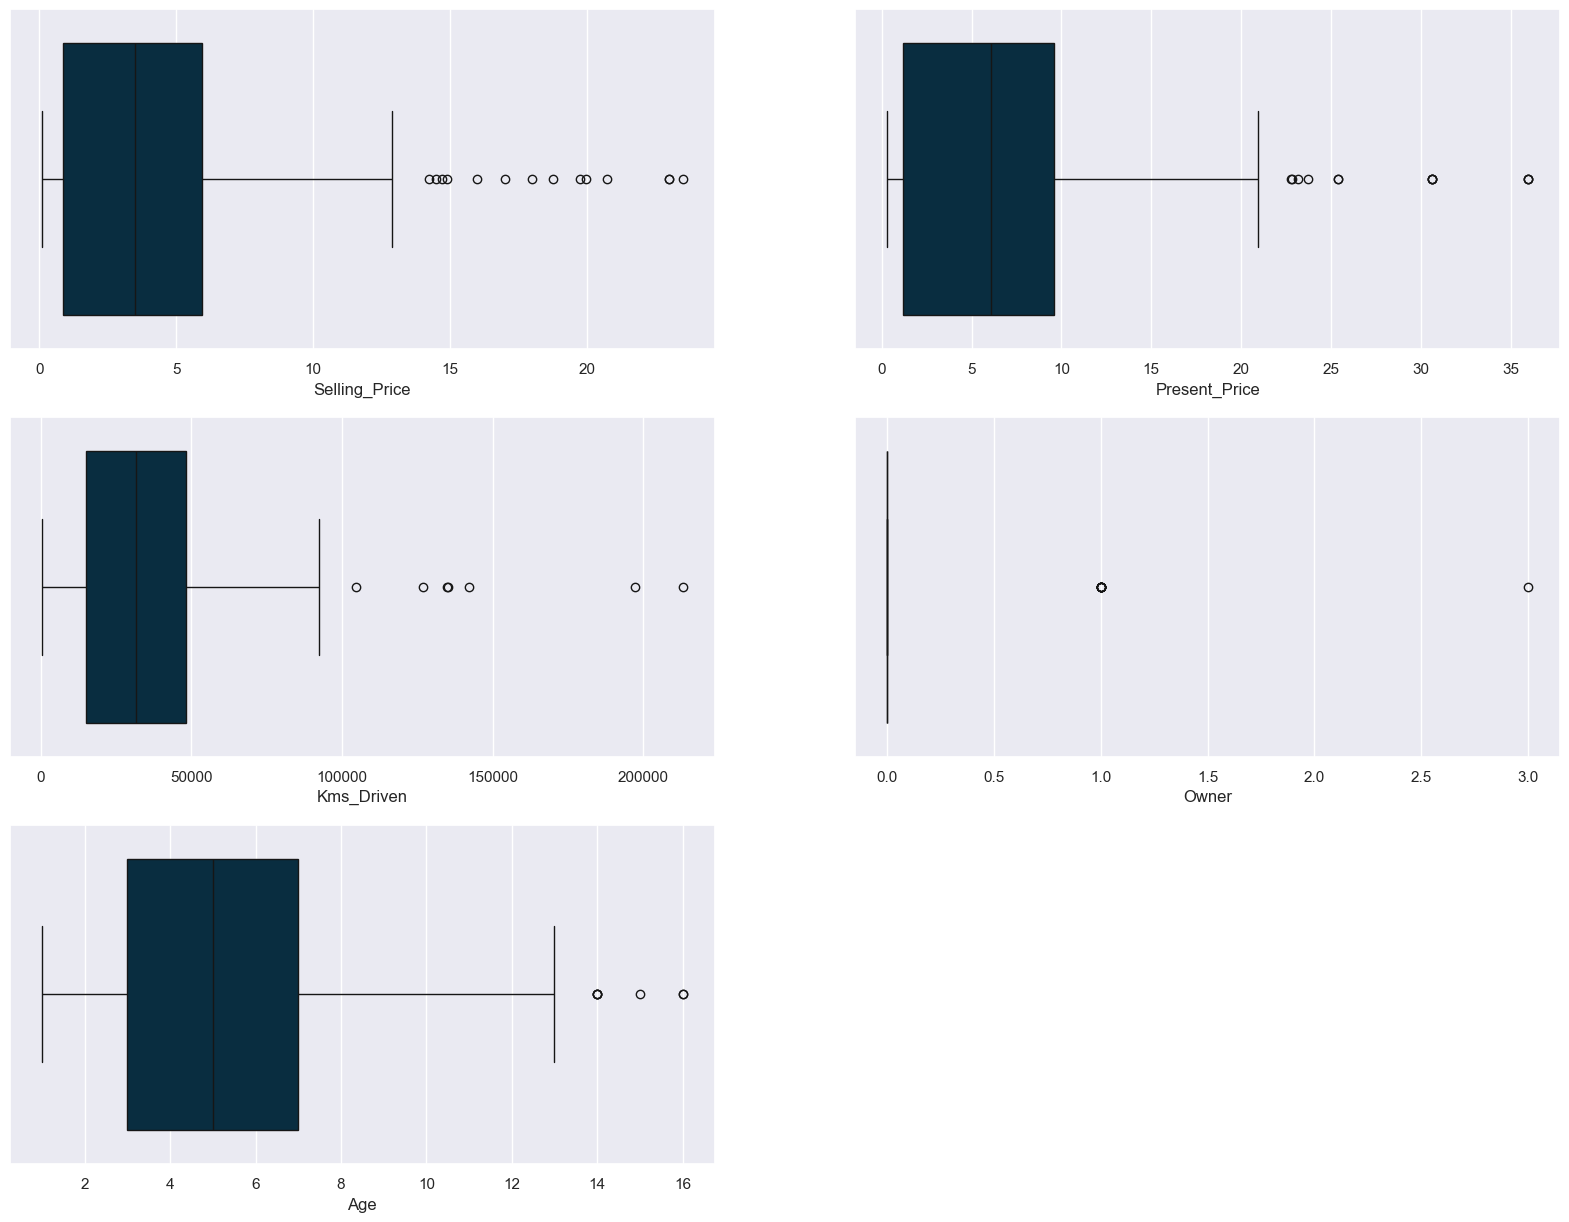

In [66]:
# Volvemos a mostrar los valores atípicos para comprobar que hayan sido borrados correctamente
# ==============================================================================
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

for i, var in enumerate(df.select_dtypes(include=[np.number])):
    sns.boxplot(data= df,
                x = var,
                ax= axes[i // 2, i % 2]
    )
    
fig.delaxes(ax= axes[2,1])

### Análisis Univariado
Para entender mejor la composición de nuestro conjunto de datos, procederemos a realizar un análisis univariado de las variables numéricas. Crearemos histogramas para cada una de estas variables, lo que nos permitirá visualizar la distribución de sus valores. Esto nos brindará una idea clara de cómo se reparten los datos dentro de cada característica numérica, identificando si tienen distribuciones normales, sesgadas, o si presentan picos y valles que necesitemos considerar.

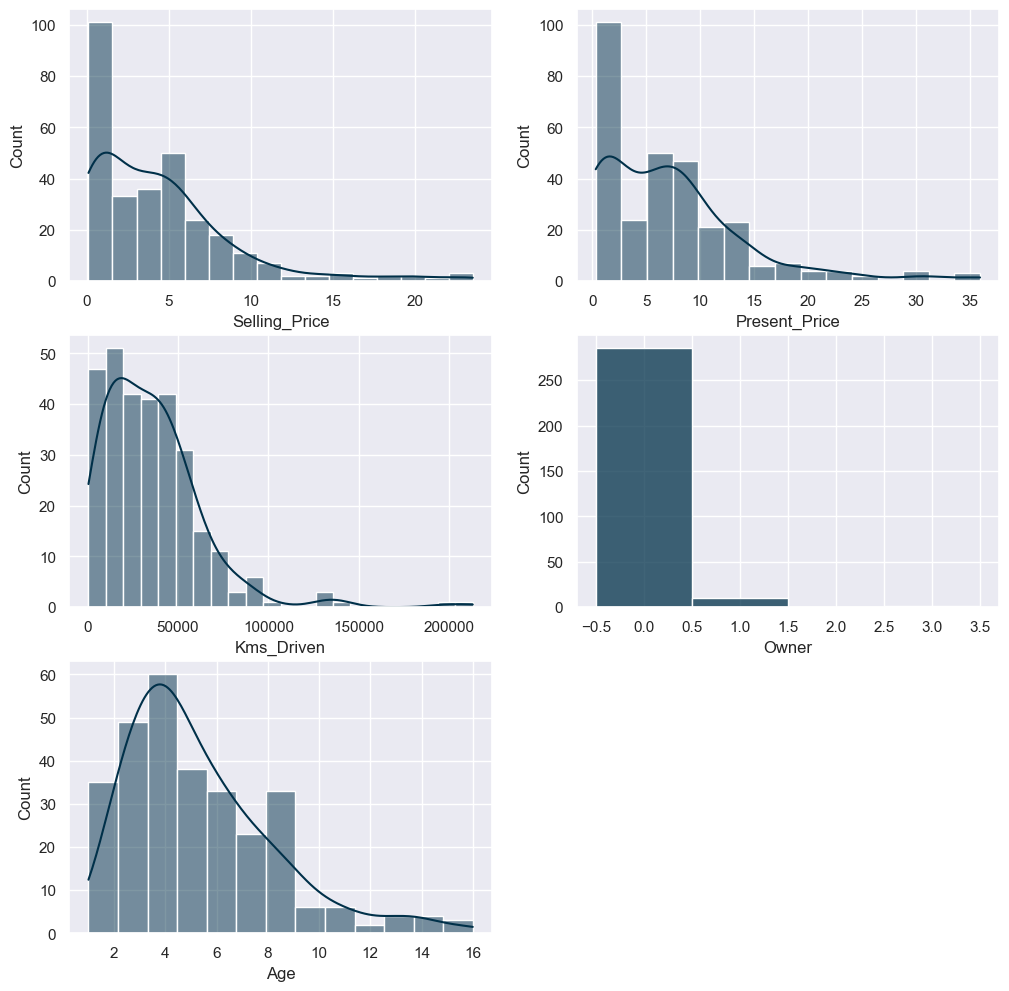

In [67]:
# Creamos los Histogramas de las variables Numericas
# ==============================================================================
fig, axes = plt.subplots(nrows= 3,ncols=2, figsize= (12, 12))

for i, var in enumerate(df.select_dtypes(include= [np.number])):
    fila = i // 2
    columna = i % 2
    if(var == "Owner"):
        sns.histplot(data = df, x = var, discrete= True, ax= axes[fila, columna ])
    else:
        sns.histplot(data = df, x = var, ax= axes[fila, columna], kde= True)
        
fig.delaxes(ax=axes[2,1])

### Transformación de Variables Categóricas a Numéricas
Para preparar nuestro conjunto de datos para el entrenamiento del modelo de regresión, es indispensable transformar todas las variables categóricas a un formato numérico. Los modelos de regresión están diseñados para trabajar exclusivamente con valores numéricos, por lo que este paso es esencial y previo a la generación de cualquier modelo. Esta conversión nos permitirá codificar la información cualitativa de las categorías en un formato que el algoritmo de regresión pueda procesar y entender

In [68]:
# Realizamos la transformación de variables cualitativas hacia variables cuantitativas
# ==============================================================================
df = pd.get_dummies(data= df, columns=['Fuel_Type', 'Seller_Type', 'Transmission'], drop_first= True)

# Multiplicamos * para transformar los valores Booleanos a Numéricos
# ==============================================================================
df = df * 1

### Análisis de Correlación

Para comprender la relación entre las diferentes variables de nuestro conjunto de datos, procederemos a calcular la correlación utilizando el coeficiente de Pearson. Este método nos permitirá cuantificar la fuerza y dirección de la relación lineal entre cada par de variables, lo que es fundamental para identificar cuáles características están más fuertemente asociadas con el precio del vehículo y entre sí.

<Axes: >

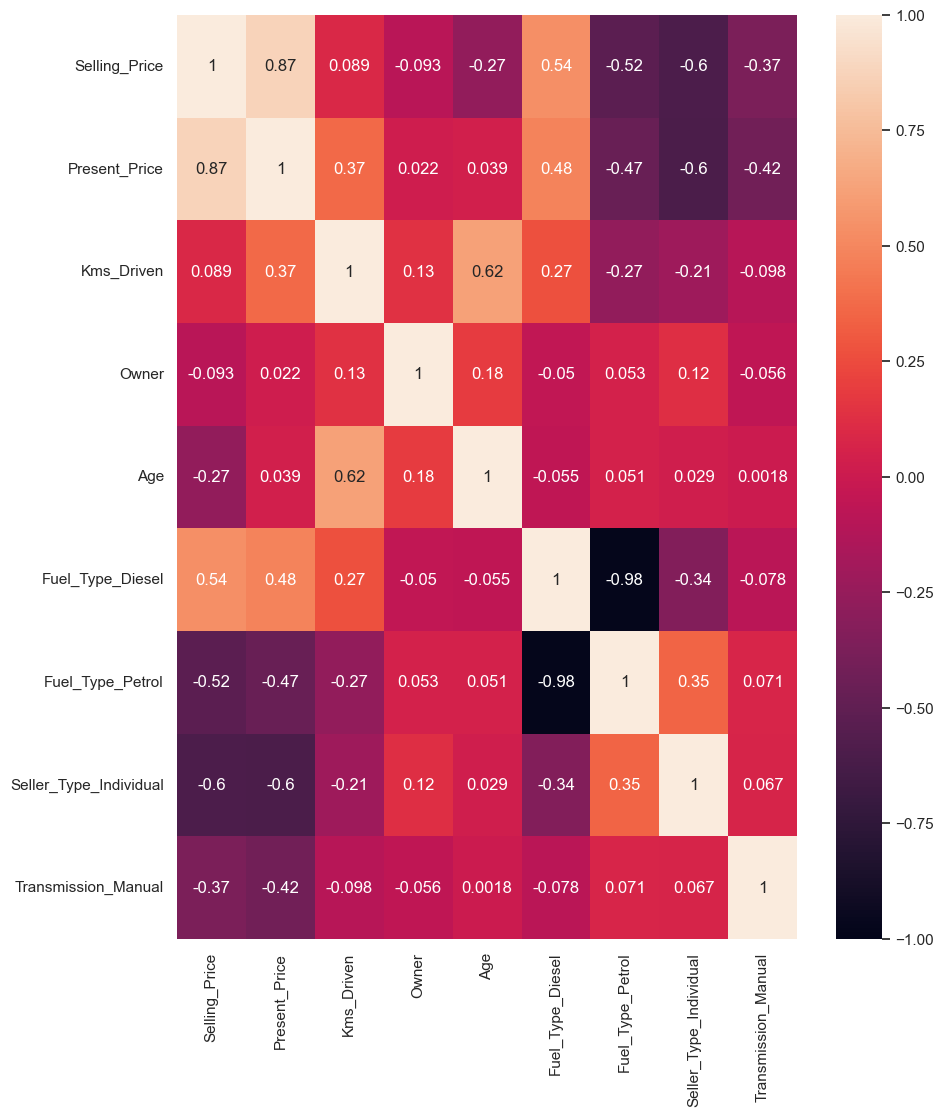

In [69]:
# Creamos el Gráfico de Calor que representa la correlación de las variables
# ==============================================================================
fig, axes = plt.subplots(figsize= (10, 12))

sns.heatmap(df.corr(method= 'pearson', numeric_only= True), annot= True, vmin= -1, ax = axes)

In [70]:
# Mantenemos una referencia del DataFrame Original Como Buena Practica
# ==============================================================================
df_original = df

### División del Conjunto de Datos en Entrenamiento y Prueba
El siguiente paso crucial en la construcción de nuestro modelo es dividir el conjunto de datos. Primero, separaremos las variables independientes, que son las que usaremos para hacer las predicciones, de la variable dependiente, que es lo que queremos predecir, en este caso, el precio del vehículo.

Una vez realizada esta distinción, procederemos dividiremos el conjunto de datos en dos subconjuntos: datos de entrenamiento y datos de prueba. Los datos de entrenamiento serán los que el modelo utilizará para aprender los patrones y relaciones entre las variables. Los datos de prueba, por otro lado, se mantendrán completamente separados y serán utilizados, una vez que el modelo haya sido entrenado, para evaluar su rendimiento y capacidad de generalización a datos no vistos.

In [71]:
# Dividimos el conjunto de datos en las variables independientes y la variable dependiente
# ==============================================================================
X = df.drop(columns="Selling_Price")
y = df["Selling_Price"]


In [72]:
# Volvemos a dividir los datos en un conjunto de entrenamiento y otro de Test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 1234, shuffle= True)
print(f"Dimensiones del X_train: {X_train.shape}")
print(f"Dimensiones del X_test: {X_test.shape}")
print(f"Dimensiones del y_train : {y_train.shape}")
print(f"Dimensiones del y_test: {y_test.shape}")

Dimensiones del X_train: (222, 8)
Dimensiones del X_test: (74, 8)
Dimensiones del y_train : (222,)
Dimensiones del y_test: (74,)


### Normalización de Datos
Para optimizar el rendimiento de nuestro modelo de regresión, es crucial realizar la normalización de los datos. Este proceso asegura que todas las variables numéricas se encuentren en la misma escala, evitando que aquellas con rangos de valores más amplios dominen indebidamente el cálculo de los coeficientes del modelo.

Aplicaremos la normalización utilizando el método Z-score, este método transforma los datos para que tengan una media de cero y una desviación estándar de uno. De esta manera, cada punto de datos se escala en función de la media y la variabilidad de su propia característica, lo que contribuye a que el modelo de regresión no se vea afectado por las diferencias de escala entre las variables.

In [73]:
# Escalamos los datos
# ==============================================================================
escalador = StandardScaler()

X_train_escaled = escalador.fit_transform(X_train)
X_test_escaled = escalador.transform(X_test)

### Creación y Entrenamiento del Modelo de Regresión Lineal
Ahora es el momento de crear nuestro modelo de regresión lineal. Entrenaremos este modelo utilizando el conjunto de datos de entrenamiento, que ya incluye las características independientes escaladas, ademas, es importante recordar que la variable dependiente, la cual es el precio del vehículo, no necesita ser escalada, ya que nuestro objetivo es predecir su valor real. Con las características preparadas, el modelo aprenderá las relaciones entre ellas y el precio para realizar predicciones precisas.

In [74]:
# Entrenamos el modelo con el conjunto de prueba escalado
# ==============================================================================
model_sklearn = LinearRegression()
model_sklearn.fit(X_train_escaled, y_train)

LinearRegression()

Una vez que nuestro modelo de regresión lineal ha sido entrenado, el siguiente paso es realizar predicciones sobre el conjunto de datos de prueba. Esto nos permitirá obtener los valores de precio estimados por el modelo para vehículos que nunca ha "visto" antes.

Posteriormente, utilizaremos estas predicciones para calcular el rendimiento del modelo a través de métricas clave. Una de las más importantes será el coeficiente de determinación $R^2$, que nos indicará qué proporción de la varianza total de la variable dependiente es explicada por nuestro modelo.

In [75]:
# Realizamos la predicción con el modelo entrenado sobre el conjunto de datos de prueba
# ==============================================================================
y_pred = model_sklearn.predict(X_test_escaled)

In [76]:
# Calculamos la metrica de Bondad de Ajuste por medio del coeficiente de determinación R^2
# ==============================================================================
metrics.r2_score(y_true= y_test, y_pred= y_pred)

0.8996488758037923

Hemos obtenido un coeficiente de determinación $R^2$ de 0.89 para nuestro modelo. Este valor es bastante positivo, ya que nos indica que el modelo es capaz de explicar aproximadamente el 89% de la variabilidad del precio de los vehículos basándose en las características que hemos utilizado.

### Función para la Validación Cruzada
Para obtener una estimación más robusta del rendimiento de nuestro modelo, vamos a implementar la validación cruzada.Ademas, utilizaremos `RepeatedKFold()`, lo que no solo divide el conjunto de datos en múltiples pliegues, sino que también repite este proceso varias veces, variando los intervalos de los pliegues en cada repetición. Esta técnica genera una evaluación mucho más fiable del modelo, ya que reduce la dependencia de una única división de los datos.

Encapsularemos esta lógica en una función. Esto nos permitirá reutilizarla fácilmente para evaluar otros modelos que implementaremos más adelante, asegurando una metodología de evaluación consistente. De esta función, obtendremos métricas clave de bondad de ajuste, incluyendo el Error Absoluto Medio - MAE, la Raíz del Error Cuadrático Medio -RMSE y el coeficiente de determinación - $R^2$, tanto para el conjunto de entrenamiento como para el de prueba.

In [77]:
# Creamos la función para realizar la validación Cruzada
# ==============================================================================
def cross_validation (model, X, y):
    k_folds = RepeatedKFold(n_splits=5, n_repeats= 3, random_state=42)
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
    resultados = cross_validate(
                    estimator = model,
                    X         = X,
                    y         = y,
                    scoring   = scoring,
                    cv        = k_folds,
                    return_train_score= True
                )
    MAE_mean_train = (-resultados['train_neg_mean_absolute_error']).mean()
    MAE_std_train = (-resultados['train_neg_mean_absolute_error']).std()
    MSE_mean_train = (-resultados['train_neg_mean_squared_error']).mean()
    MSE_std_train = (-resultados['train_neg_mean_squared_error']).std()
    RMSE_mean_train = (-resultados['train_neg_root_mean_squared_error']).mean()
    RMSE_std_train = (-resultados['train_neg_root_mean_squared_error']).std()
    R2_Score_mean_train = resultados['train_r2'].mean()
    R2_Score_std_train = resultados['train_r2'].std()

    MAE_mean = (-resultados['test_neg_mean_absolute_error']).mean()
    MAE_std = (-resultados['test_neg_mean_absolute_error']).std()
    MSE_mean = (-resultados['test_neg_mean_squared_error']).mean()
    MSE_std = (-resultados['test_neg_mean_squared_error']).std()
    RMSE_mean = (-resultados['test_neg_root_mean_squared_error']).mean()
    RMSE_std = (-resultados['test_neg_root_mean_squared_error']).std()
    R2_Score_mean = resultados['test_r2'].mean()
    R2_Score_std = resultados['test_r2'].std()

    DataFrame = pd.DataFrame({ 'Mean_train': [MAE_mean_train, MSE_mean_train, RMSE_mean_train, R2_Score_mean_train],
                'Std_train': [MAE_std_train, MSE_std_train, RMSE_std_train, R2_Score_std_train],
                'Mean_test': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 
                'Std_test': [MAE_std,MSE_std,RMSE_std,R2_Score_std]})
    print(DataFrame)

Para automatizar y estandarizar el proceso de evaluación en cada iteración de la validación cruzada, vamos a construir un Pipeline. Este Pipeline encapsulará una secuencia de pasos que se ejecutarán de forma automática y consistente:

- Primero, el Pipeline se encargará de escalar las características en cada subconjunto de datos (entrenamiento y prueba) generado por la validación cruzada. Esto asegura que la normalización se aplique correctamente en cada fold, replicando el proceso que seguiríamos en un entorno de producción.

-  Inmediatamente después del escalado, el Pipeline procederá a entrenar el modelo de regresión lineal con los datos escalados del conjunto de entrenamiento de la iteración actual.

- Una vez entrenado el modelo, el Pipeline calculará y registrará las métricas de bondad de ajuste (como MAE, RMSE y $R^2$ para el conjunto de prueba de esa iteración.

Una vez que todas las iteraciones de la validación cruzada hayan finalizado, la función calculará la media de todas las métricas de bondad de ajuste obtenidas. Esto nos proporcionará una estimación más fiable y menos sesgada del rendimiento general de nuestro modelo.

In [78]:
# Creamos el Pipeline y lo enviamos como argumento a la función que realiza la Validación Cruzada
# ==============================================================================
pipeline = make_pipeline(StandardScaler(), LinearRegression())
cross_validation(pipeline, X, y)

   Mean_train  Std_train  Mean_test  Std_test
0        1.02       0.03       1.07      0.12
1        2.15       0.14       2.54      0.70
2        1.47       0.05       1.58      0.22
3        0.89       0.01       0.84      0.08


Antes de finalizar la evaluación de nuestro modelo de regresión lineal, es fundamental verificar si se cumplen los supuestos clave que sustentan este tipo de análisis. Esto nos permitirá asegurar la validez y fiabilidad de nuestras inferencias. Específicamente, comprobaremos:

- Evaluaremos si los errores (residuos) del modelo se distribuyen de manera normal. Este supuesto es importante para la validez de las pruebas de hipótesis y los intervalos de confianza
- Aunque el modelo ya es lineal por definición, es crucial verificar que la relación entre las variables predictoras y la variable objetivo es, de hecho, lineal.
- Comprobaremos si la varianza de los residuos es constante en todos los niveles de las variables predictoras. La heterocedasticidad puede llevar a estimaciones de errores estándar sesgadas.

Para facilitar estas comprobaciones y permitir su reutilización en futuras secciones del Notebook, crearemos funciones específicas para cada uno de estos análisis. Esto promoverá un código más limpio y eficiente.

In [79]:
# Creamos la función que halla los residuos
# ==============================================================================
def residuals(modelo, X_test, y_test, reshape):
    """
    Calcula los residuos de un modelo de regresión.

    Parámetros:
    model (objeto): El modelo de regresión entrenado.
    X_test (array-like): Los datos de prueba para realizar las predicciones.
    y_test (array-like): Los valores reales correspondientes a los datos de prueba.
    reshape: Indica si se debe redimensionar el DataFrame, es False cuando utilizamos la transformacion No Lineal
    Retorna:
    DataFrame: Un DataFrame que contiene las columnas 'Actual', 'Predicted' y 'Residuals'.
    """
    # Realizar predicciones con los datos de prueba
    y_pred = modelo.predict(X_test)
    
    if(reshape == True):
        # Crear un DataFrame con los valores reales y los predichos
        df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    else:
        df_results = pd.DataFrame({'Actual': y_test.reshape(-1), 'Predicted': y_pred.reshape(-1)})

    # Calcular los residuos
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    # Devolver el DataFrame
    return df_results
    
def linear_assumption(model, X_test, y_test, reshape):
    """
    Comprueba la suposición lineal de un modelo de regresión lineal mediante la visualización de los valores reales y predichos,
    así como los residuos en relación con los valores predichos.

    Parámetros:
    - model: El modelo de regresión lineal entrenado.
    - X_test: Los datos de prueba para las características independientes.
    - y_test: Los datos de prueba para la variable dependiente.
    - reshape: Indica si se debe redimensionar el DataFrame, es False cuando utilizamos la transformacion No Lineal

    Retorna:
    No retorna ningún valor. Muestra dos gráficos: uno que muestra los valores reales vs. los valores predichos y otro que muestra
    los residuos vs. los valores predichos.
    """
    
    df_results = residuals(model, X_test, y_test, reshape)
    
    fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=80)
    sns.regplot(x='Actual', y='Predicted', data=df_results, lowess=True, ax=ax[0], line_kws={'color': 'orange','ls':'--','lw':2.5, 'label': 'Linea Generada'}, scatter_kws={'alpha': 0.3})
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color= "red", linewidth= 2.5, linestyle= "dashed", label= "Linea de Referencia")

    ax[0].set_title('Valores Reales vs. Valores Predichos', fontsize=15)
    ax[0].set_xlabel('Reales', fontsize=12)
    ax[0].set_ylabel('Predichos', fontsize=12)
    ax[0].legend()     
    
    sns.regplot(x='Predicted', y='Residuals', data=df_results, lowess=True, ax=ax[1], line_kws={'color': 'orange','ls':'--','lw':2.5, 'label': 'Linea Generada'}, scatter_kws={'alpha': 0.3})
    ax[1].axhline(0, color= "red", linewidth= 2.5, linestyle= "dashed", label= "Linea de Referencia")
    ax[1].set_title('Residuos vs. Valores Predichos', fontsize=15)
    ax[1].set_xlabel('Predichos', fontsize=12)
    ax[1].set_ylabel('Residuos', fontsize=12)
    ax[1].legend()

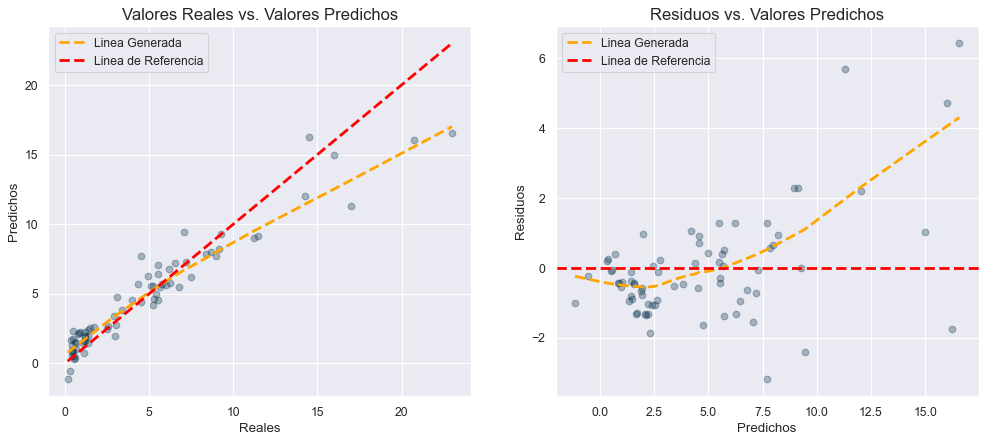

In [80]:
# Evaluamos los supuesto del modelo que hemos creado
# ==============================================================================
linear_assumption(model_sklearn, X_test_escaled, y_test.values.reshape(-1, 1), False)

In [81]:
# Creamos la función que halla el supuesto de Homocedasticidad del modelo
# ==============================================================================
def homoscedasticity_assumption(modelo, X_test, y_test, reshape):
    """
    Comprueba la suposición de homocedasticidad en un modelo de regresión lineal.

    Parameters:
    model (objeto): El modelo de regresión lineal ajustado.
    X_test (array-like): Los valores de las variables independientes para el conjunto de prueba.
    y_test (array-like): Los valores de la variable dependiente para el conjunto de prueba.

    Returns:
    None

    Muestra un gráfico de dispersión de los residuos en función de los valores predichos.
    Si los residuos están dispersos de manera uniforme alrededor de cero, se cumple la suposición de homocedasticidad.
    """

    df_results = residuals(modelo, X_test, y_test, reshape)
    
    fig = plt.figure(figsize=(6,6), dpi=80)
    
    sns.regplot(x='Predicted', 
                y='Residuals', 
                data=df_results, 
                lowess=True, 
                line_kws={'color':'red','ls':'--','lw':2.5, 'label': 'Linea Generada'},
                scatter_kws={'alpha':0.3}
                )
    
    plt.axhline(y=0, color='orange', lw= 2.5, ls= '--', label= 'Linea de Referencia')
    plt.title('Residuos vs Valores Predchos', fontsize=15, weight='bold')
    plt.xlabel('Valores Predichos', fontsize=12)
    plt.ylabel('Residuos', fontsize=12)
    plt.legend()
    plt.show()

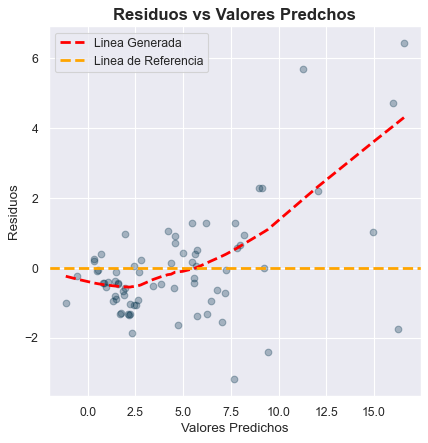

In [82]:
# Evaluamos el supuesto de Homocedasticidad del modelo creado
# =============================================================================
homoscedasticity_assumption(modelo= model_sklearn, X_test= X_test_escaled, y_test= y_test.values.reshape(-1, 1), reshape= False)

### Realizamos la transformacion yeo-johnson

Como hemos observado en las gráficas anteriores, nuestro modelo actual no cumple perfectamente todos los supuestos de la regresión lineal. Esto, lamentablemente, puede afectar la fiabilidad del modelo para la generalización a nuevos datos, ya que un incumplimiento de estos supuestos puede llevar a estimaciones de coeficientes menos precisas y a intervalos de confianza no válidos.

Para mejorar el cumplimiento de estos supuestos, especialmente el de normalidad de los residuos, podemos aplicar una transformación no lineal a nuestras variables. Esta transformación tiene el potencial de estabilizar la varianza, linealizar relaciones y normalizar las distribuciones, haciendo que el modelo sea más estable y confiable para realizar nuevas predicciones.

La transformación específica que aplicaremos es la transformación no lineal de Yeo-Johnson. Esta es una opción robusta porque, a diferencia de otras transformaciones como la de Box-Cox, puede manejar valores cero y negativos, lo que la hace muy versátil para diferentes tipos de datos. Al aplicar Yeo-Johnson, esperamos mejorar significativamente las propiedades de los datos, acercándonos al cumplimiento de los supuestos y, en consecuencia, aumentando la confianza en las predicciones de nuestro modelo.

In [83]:
# Creamos un Pipeline de Transformación del conjunto de características X
# ==============================================================================
pipeline_x = Pipeline(steps=[
    ("Tranformador_box_cox", PowerTransformer(method='yeo-johnson', standardize= False)),
    ("escalador", StandardScaler()),
    ("modelo_regresion", LinearRegression())
])

In [84]:
# Creamos un Pipeline de Transformación de la variable dependiente y
# ==============================================================================
pipeline_y = PowerTransformer(method='yeo-johnson', standardize= False)

Procederemos a crear un nuevo modelo que incorpore estas transformaciones. Este enfoque nos permitirá evaluar cómo la aplicación de Yeo-Johnson impacta en la capacidad predictiva y la robustez del modelo.

Entrenaremos este nuevo modelo utilizando los datos transformados y, posteriormente, calcularemos las métricas de bondad de ajuste (como el $R^2$, MAE y RMSE) para comparar su rendimiento con el modelo anterior. Esto nos ayudará a determinar si la transformación ha mejorado significativamente la capacidad de generalización y la fiabilidad de nuestras predicciones.

In [85]:
# Creamos el modelo con las transformaciones
# ==============================================================================
modelo_yeo_johnson = TransformedTargetRegressor(
    regressor= pipeline_x,
    transformer= pipeline_y
)

In [86]:
# Realizamos la validación cruzada de el nuevo modelo y obtenemos las métricas
# ==============================================================================
cross_validation(modelo_yeo_johnson, X, y)

   Mean_train  Std_train  Mean_test  Std_test
0        0.65       0.03       0.69      0.12
1        1.06       0.09       1.28      0.60
2        1.03       0.05       1.11      0.24
3        0.94       0.01       0.93      0.03


Hemos logrado un aumento notable en el rendimiento del modelo gracias a la aplicación de las transformaciones Yeo-Johnson.

Originalmente, nuestro modelo presentaba un coeficiente de determinación $R^2$ del 84% con una desviación estándar promedio de 0.08. Tras incorporar las transformaciones, hemos alcanzado un impresionante $R^2$   del 93%, y lo que es aún más importante, la desviación estándar se ha reducido drásticamente a solo 0.03.

Esta mejora no solo indica que nuestro modelo ahora explica una mayor proporción de la variabilidad en el precio de los vehículos, sino que también es mucho más consistente y robusto en sus predicciones. Es evidente que las transformaciones Yeo-Johnson han sido beneficiosas para optimizar el rendimiento y la fiabilidad de nuestro modelo de regresión.

Ahora, para validar visualmente estos beneficios, vamos a entrenar el modelo final con las transformaciones Yeo-Johnson aplicadas y, posteriormente, observar a través de representaciones gráficas si los supuestos de la regresión lineal se cumplen de manera más adecuada. Esto nos permitirá confirmar cómo estas transformaciones han impactado positivamente la distribución de los residuos y otras propiedades clave del modelo.

In [87]:
# Entrenamos el nuevo modelo
# ==============================================================================
modelo_yeo_johnson.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('Tranformador_box_cox',
                                                      PowerTransformer(standardize=False)),
                                                     ('escalador',
                                                      StandardScaler()),
                                                     ('modelo_regresion',
                                                      LinearRegression())]),
                           transformer=PowerTransformer(standardize=False))

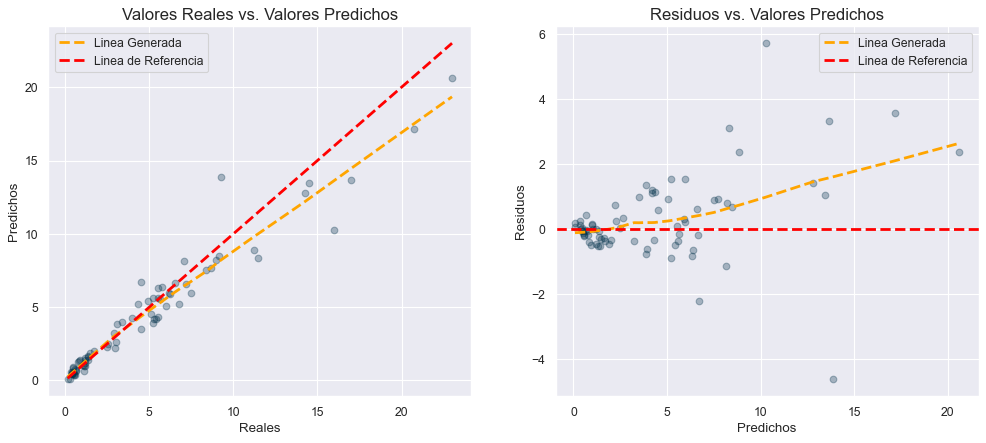

In [88]:
# Evaluamos el supuesto de linealidad del nuevo modelo
# ==============================================================================
linear_assumption(modelo_yeo_johnson, X_test, y_test, True)

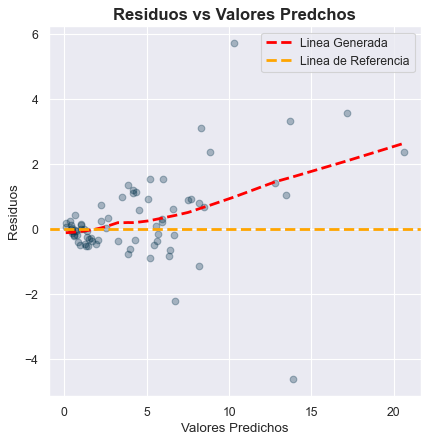

In [89]:
# Evaluamos el supuesto de Homocedasticidad del nuevo modelo
# ==============================================================================
homoscedasticity_assumption(modelo= modelo_yeo_johnson, X_test= X_test, y_test= y_test, reshape=True)

### Creación de Características Polinomiales y Evaluación Inicial del Modelo
Para capturar interacciones no lineales entre las variables y potencialmente mejorar la capacidad de nuestro modelo, vamos a crear un conjunto de características polinomiales de segundo grado. Esto significa que, además de las características originales, incluiremos términos que representan el cuadrado de cada característica y los productos de pares de características (interacciones).

Una vez generado este nuevo conjunto de datos con las características polinomiales, procederemos a dividirlo nuevamente en conjuntos de entrenamiento y prueba. Con estos datos preparados, entrenaremos un modelo de regresión lineal inicial. El objetivo de este paso es observar el comportamiento y rendimiento de un modelo de regresión lineal cuando se le proporcionan características de segundo grado, lo que nos dará una base para futuras optimizaciones.

In [90]:
# Creamos los parametrios para la creación del conjunto de características de segundo
caracteristicas_poly_grado2 = PolynomialFeatures(degree= 2, include_bias= False)

In [91]:
# Creamos el nuevo conjunto de datos con términos Polinomiales de Segundo Grado
# ==============================================================================
X_poly = caracteristicas_poly_grado2.fit_transform(X)
X_poly = pd.DataFrame(data= X_poly, columns= caracteristicas_poly_grado2.get_feature_names_out(X.columns)) 
X_poly

,Present_Price,Kms_Driven,Owner,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,Present_Price^2,Present_Price Kms_Driven,...,Fuel_Type_Diesel^2,Fuel_Type_Diesel Fuel_Type_Petrol,Fuel_Type_Diesel Seller_Type_Individual,Fuel_Type_Diesel Transmission_Manual,Fuel_Type_Petrol^2,Fuel_Type_Petrol Seller_Type_Individual,Fuel_Type_Petrol Transmission_Manual,Seller_Type_Individual^2,Seller_Type_Individual Transmission_Manual,Transmission_Manual^2
0,5.59,27000.00,0.00,5.00,0.00,1.00,0.00,1.00,31.25,150930.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00
1,9.54,43000.00,0.00,6.00,1.00,0.00,0.00,1.00,91.01,410220.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2,9.85,6900.00,0.00,2.00,0.00,1.00,0.00,1.00,97.02,67965.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00
3,4.15,5200.00,0.00,8.00,0.00,1.00,0.00,1.00,17.22,21580.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00
4,6.87,42450.00,0.00,5.00,1.00,0.00,0.00,1.00,47.20,291631.50,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,11.60,33988.00,0.00,3.00,1.00,0.00,0.00,1.00,134.56,394260.80,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
292,5.90,60000.00,0.00,4.00,0.00,1.00,0.00,1.00,34.81,354000.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00
293,11.00,87934.00,0.00,10.00,0.00,1.00,0.00,1.00,121.00,967274.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00
294,12.50,9000.00,0.00,2.00,1.00,0.00,0.00,1.00,156.25,112500.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


In [92]:
# Realizamos la division del conjunto de Prueba y Test
# ==============================================================================
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size= 0.25, random_state= 1234, shuffle= True)
print(f"Dimensiones del X_train: {X_train_poly.shape}")
print(f"Dimensiones del X_test: {X_test_poly.shape}")
print(f"Dimensiones del y_train : {y_train_poly.shape}")
print(f"Dimensiones del y_test: {y_test_poly.shape}")

Dimensiones del X_train: (222, 44)
Dimensiones del X_test: (74, 44)
Dimensiones del y_train : (222,)
Dimensiones del y_test: (74,)


Ahora que hemos generado nuestro conjunto de datos con características polinomiales de segundo grado, el siguiente paso es crear un modelo de regresión lineal utilizando este nuevo conjunto de datos. Este modelo estará diseñado para capturar las relaciones más complejas que los términos polinomiales permiten.

Una vez creado, evaluaremos el rendimiento de este modelo exhaustivamente mediante la validación cruzada. Como hemos establecido previamente, utilizaremos nuestra función de validación cruzada con `RepeatedKFold()` para obtener métricas robustas (MAE, RMSE, $R^2$) y entender cómo se comporta este modelo en diferentes subconjuntos de datos, asegurando una estimación fiable de su capacidad de generalización.

In [93]:
# Creamos el Pipeline y evaluamos el modelo sobre el conjunto de datos de segundo grado
# ==============================================================================
pipeline = make_pipeline(StandardScaler(), LinearRegression())
cross_validation(model= pipeline, X= X_poly, y= y)

   Mean_train  Std_train                      Mean_test  \
0        0.43       0.02                447190642328.81   
1        0.37       0.02 139231663429259746972008448.00   
2        0.61       0.02               3349769671072.33   
3        0.98       0.00  -9431175512253322762387456.00   

                        Std_test  
0               1473887111488.81  
1 517260212410100163935207424.00  
2              11314181657549.24  
3  35039953980887864891670528.00  


Al evaluar el modelo con características polinomiales, hemos identificado un claro caso de sobreajuste (overfitting). Observamos un coeficiente de determinación $R^2$ del 98% en el conjunto de entrenamiento, lo que sugiere que el modelo se ajusta excesivamente bien a los datos con los que aprendió. Sin embargo, en el conjunto de prueba, hemos obtenido un $R^2$ negativo. Un $R^2$ negativo es un indicador preocupante que implica que el modelo es peor que un modelo que simplemente predice la media, confirmando que nuestro modelo no está generalizando bien a datos nuevos y no vistos.

Para mitigar este sobreajuste y mejorar la capacidad de generalización del modelo, es necesario aplicar la técnica de regularización Lasso. Lasso penaliza los coeficientes de las variables, lo que ayuda a reducir su magnitud y, en algunos casos, a establecerlos en cero, realizando una selección de características.

Por lo tanto, el primer paso antes de aplicar Lasso será escalar las variables de nuestro conjunto de características polinomial. Esto es fundamental para que la regularización funcione de manera efectiva, ya que Lasso es sensible a la escala de las características.

In [94]:
# Escalamos los datos del conjunto de Segundo Grado
# ==============================================================================
escalador = StandardScaler()
X_train_poly_escaled = escalador.fit_transform(X_train_poly)
X_test_poly_escaled = escalador.transform(X_test_poly)

Creamos el modelo de regularizacion Lasso y lo Una vez que nuestras características polinomiales están escaladas, procederemos a crear y entrenar el modelo de regresión con regularización Lasso. Este modelo aplicará una penalización a los coeficientes de las variables, lo que nos ayudará a mitigar el sobreajuste y a identificar las características más relevantes para la predicción del precio de los vehículos. Al entrenarlo, Lasso buscará un equilibrio entre ajustar los datos y mantener la complejidad del modelo bajo control, lo que se traducirá en una mejor capacidad de generalización.

In [95]:

# Creamos el modelo de Regularizacion Lasso y lo entrenamos con los datos de entrenamiento escalados
# ==============================================================================
modelo_lasso_CV = LassoCV( alphas = np.logspace(-10, 1, 200), max_iter= 1000,fit_intercept = True, cv = 10, verbose= True, random_state=0)
modelo_lasso_CV.fit(X_train_poly_escaled, y_train_poly)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=array([1.00000000e-10, 1.13573336e-10, 1.28989026e-10, 1.46497140e-10,
       1.66381689e-10, 1.88965234e-10, 2.14614120e-10, 2.43744415e-10,
       2.76828663e-10, 3.14403547e-10, 3.57078596e-10, 4.05546074e-10,
       4.60592204e-10, 5.23109931e-10, 5.94113398e-10, 6.74754405e-10,
       7.66341087e-10, 8.70359136e-10, 9.88495905e-10, 1.12266777e-09,
       1.27505124e-09, 1.44811823e-0...
       5.35356668e-01, 6.08022426e-01, 6.90551352e-01, 7.84282206e-01,
       8.90735464e-01, 1.01163798e+00, 1.14895100e+00, 1.30490198e+00,
       1.48202071e+00, 1.68318035e+00, 1.91164408e+00, 2.17111795e+00,
       2.46581108e+00, 2.80050389e+00, 3.18062569e+00, 3.61234270e+00,
       4.10265811e+00, 4.65952567e+00, 5.29197874e+00, 6.01027678e+00,
       6.82607183e+00, 7.75259749e+00, 8.80488358e+00, 1.00000000e+01]),
        cv=10, random_state=0, verbose=True)

Ahora, hallaremos el Alpha obtenido del modelo entrenado

In [96]:
# Hallamos el Valor Alpha del modelo que hemos entrenado
# ==============================================================================
modelo_lasso_CV.alpha_

0.0032929712550971548

Con el valor de α óptimo ya determinado, el siguiente paso es crear un nuevo modelo de regresión Lasso utilizando este parámetro específico

In [97]:
# Creamos el modelo Lasso con el Alpha Obtenido de la Busqueda
# ==============================================================================
modelo_lasso = Lasso(alpha= modelo_lasso_CV.alpha_)

In [98]:
# Creamos el Pipeline y Evaluamos el modelo que aplica la Regularizacion Lasso
# ==============================================================================
pipeline = make_pipeline(StandardScaler(), modelo_lasso)
cross_validation(model= pipeline, X= X_poly, y= y)


   Mean_train  Std_train  Mean_test  Std_test
0        0.44       0.02       0.55      0.07
1        0.39       0.02       0.73      0.24
2        0.62       0.02       0.84      0.14
3        0.98       0.00       0.96      0.02


La implementación del modelo con regularización Lasso ha resultado en una mejora sustancial y un modelo mucho más robusto. Hemos logrado un coeficiente de determinación $R^2$ del 96%, lo que indica que el modelo explica una altísima proporción de la variabilidad en el precio de los vehículos. Más impresionante aún, la desviación estándar se ha reducido a tan solo 0.02, lo que demuestra una consistencia excepcional en las predicciones del modelo.

Ahora, para comprender mejor la simplicidad y la interpretabilidad de este modelo regularizado, procederemos a identificar la cantidad de predictores que realmente está utilizando. Para ello, contaremos el número de características (predictores) cuyos coeficientes son distintos de cero. Esto nos revelará cómo Lasso ha realizado una selección automática de características, descartando aquellas que no son relevantes y enfocándose en las que más influyen en la predicción del precio del vehículo.

In [99]:
# Entrenamos el modelo con los datos de entrenamiento escalados
# ==============================================================================
modelo_lasso.fit(X_train_poly_escaled, y_train_poly)

Lasso(alpha=0.0032929712550971548)

In [100]:
# Hallamos los coeficiente del modelo que son diferentes a cero
# ==============================================================================
df_coeficientes_modelo_lasso_solo = pd.DataFrame(
    {'predictor': X_train_poly.columns,
     'Coeficiente' : modelo_lasso.coef_}    
)
df_coeficientes_modelo_lasso_solo[df_coeficientes_modelo_lasso_solo['Coeficiente'] != 0]


,predictor,Coeficiente
0,Present_Price,7.22
1,Kms_Driven,-0.18
3,Age,-0.55
4,Fuel_Type_Diesel,-0.70
5,Fuel_Type_Petrol,0.10
8,Present_Price^2,-2.08
9,Present_Price Kms_Driven,-0.64
10,Present_Price Owner,0.01
11,Present_Price Age,-2.94
12,Present_Price Fuel_Type_Diesel,1.98


In [101]:
# Imprimimos la cantidad de coeficientes distintos a cero
# ==============================================================================
print("Predictores Utilizados por el modelo:", df_coeficientes_modelo_lasso_solo[df_coeficientes_modelo_lasso_solo['Coeficiente'] != 0].shape[0])

Predictores Utilizados por el modelo: 26


Hemos confirmado la eficacia de la regularización Lasso en la selección de características: nuestro modelo actual está utilizando 26 características de las 44 disponibles en el conjunto de características polinomiales. Esto ya representa una simplificación significativa y una mejora en la interpretabilidad del modelo.

Sin embargo, hay una oportunidad para disminuir aún más la cantidad de características utilizadas sin una pérdida significativa de precisión. Esto se logra ajustando el valor de α (el parámetro de regularización) en el modelo Lasso. Específicamente, podemos optar por un valor de α que se encuentre a una desviación estándar del α óptimo que minimiza el error, tal como se determina comúnmente en el modelo LassoCV().

Al hacer esto, elegimos un modelo ligeramente más penalizado que, aunque puede tener un error marginalmente mayor, resultará en un modelo mucho más esparso (con menos características) y, por lo tanto, más interpretable y menos propenso a sobreajuste, especialmente si el conjunto de datos es ruidoso o tiene características redundantes. Esta estrategia nos permite encontrar un excelente equilibrio entre la precisión del modelo y su complejidad.

In [102]:
# Evolución del error en función de alpha
# ==============================================================================
mse_cv = modelo_lasso_CV.mse_path_.mean(axis=1)
mse_sd = modelo_lasso_CV.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo_lasso_CV.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo_lasso_CV.alphas_[rmse_cv == min_rsme_1sd]

Para afinar aún más nuestro modelo Lasso y buscar el equilibrio ideal entre la precisión y la esparsa de características, vamos a implementar una estrategia de optimización más detallada. Crearemos una tabla con 100 divisiones de valores para el parámetro α. Este rango se extenderá desde el α óptimo que hemos identificado (el que minimiza el error) hasta un valor que representa el α óptimo más una desviación estándar.

Para cada uno de estos 100 valores de α, realizaremos una validación cruzada. Este enfoque nos permitirá evaluar cómo el rendimiento del modelo (y, crucialmente, el número de características seleccionadas) varía a medida que aumentamos ligeramente la penalización. Al analizar los resultados de estas 100 validaciones, podremos tomar una decisión informada sobre el valor de α que ofrece la mejor combinación de precisión y simplicidad, favoreciendo un modelo aún más interpretable y robusto.

In [103]:
# Evaluamos el modelo con un valor de Alpha Optimo
# ==============================================================================
modelos_tabla = pd.DataFrame(columns=["Alpha", "Mean_train", "Std_train", "Mean_test", "Std_test", "cantidad_coeficientes"])
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']

for i, alpha in enumerate(np.linspace(optimo, optimo_1sd ,100 ).flatten()):
    lasso = Lasso(alpha= alpha)
    
    k_folds = RepeatedKFold(n_splits=5, n_repeats=3, random_state=18)
    pipeline = make_pipeline(StandardScaler(), lasso)
    
    resultados = cross_validate(
        estimator = pipeline,
        X         = X_poly,
        y         = y,
        scoring   = scoring,
        cv        = k_folds,
        return_train_score= True
        )
    lasso.fit(X_train_poly_escaled, y_train_poly)
    coeficientes = (lasso.coef_ != 0).sum()
    
    R2_Score_std = resultados['test_r2'].std()
    R2_Score_mean = resultados['test_r2'].mean()
    R2_Score_std_train = resultados['train_r2'].std()
    R2_Score_mean_train = resultados['train_r2'].mean()
    
    
    modelos_tabla.loc[i] = {"Alpha": alpha, "Mean_train": R2_Score_mean_train , "Std_train": R2_Score_std_train, "Mean_test": R2_Score_mean, "Std_test": R2_Score_std, "cantidad_coeficientes" : coeficientes}
    
modelos_tabla.sort_values("Mean_test", ascending= False).head(20)

,Alpha,Mean_train,Std_train,Mean_test,Std_test,cantidad_coeficientes
1,0.01,0.98,0.00,0.96,0.02,24
2,0.01,0.98,0.00,0.96,0.02,23
3,0.01,0.98,0.00,0.96,0.02,23
4,0.01,0.98,0.00,0.96,0.02,24
5,0.01,0.98,0.00,0.96,0.02,22
0,0.00,0.98,0.00,0.96,0.02,26
6,0.01,0.98,0.00,0.96,0.02,21
7,0.02,0.97,0.00,0.96,0.02,20
8,0.02,0.97,0.00,0.96,0.02,20
9,0.02,0.97,0.00,0.96,0.02,16


Después de nuestra exploración detallada de los valores de α y sus impactos en el modelo Lasso, hemos llegado a una conclusión muy valiosa. Hemos identificado que es posible construir un modelo que utiliza tan solo 15 predictores, en lugar de los 26 del anterior modelo.

Lo más impresionante es que esta significativa reducción en la complejidad del modelo mantiene prácticamente el mismo rendimiento predictivo: un coeficiente de determinación $R^2$ del 96% con una desviación estándar de solo 0.02. Esto demuestra que el modelo es altamente eficiente, logrando una precisión excepcional con un número mucho menor de características, lo que lo hace más interpretable y menos propenso a ruido innecesario. Esta optimización es crucial para un modelo robusto y fácil de desplegar.

In [104]:
# Capturamos el Alpha del modelo con 15 predictores y un coeficiente de determinación promedio de 0.96
# ==============================================================================
coeficientes_optimo = modelos_tabla["Alpha"][13]

hora que hemos identificado el valor óptimo de α que nos permite obtener un modelo más simple sin sacrificar rendimiento, procederemos a entrenar nuestro modelo Lasso final con este valor específico. Este modelo incorporará la penalización ajustada que resulta en el uso de solo 15 predictores, manteniendo el impresionante coeficiente de determinación del 96%.

Una vez entrenado, realizaremos una evaluación de rendimiento sobre el conjunto de prueba utilizando el coeficiente de determinación $R^2$ Esta evaluación final nos confirmará la capacidad de generalización de nuestro modelo optimizado a datos no vistos, consolidando la confianza en su habilidad para predecir el precio de los vehículos de manera precisa y eficiente.

In [105]:
# Creamos el modelo y lo entrenamos con los datos de prueba
# ==============================================================================
modelo_final_lasso = Lasso(alpha= coeficientes_optimo )
modelo_final_lasso.fit(X_train_poly_escaled, y_train_poly)

Lasso(alpha=0.028255099025557145)

In [106]:
# Calculamos las predicciones del modelo en base al conjunto de prueba
# ==============================================================================
y_pred_lasso = modelo_final_lasso.predict(X_test_poly_escaled)

Ahora que el modelo Lasso optimizado ha sido entrenado con el valor de α final, procederemos a calcular su coeficiente de determinación $R^2$

In [107]:
# Hallamos la métrica de bondad de ajuste del modelo
metrics.r2_score(y_true= y_test_poly, y_pred= y_pred_lasso)

0.9751772892133382

Nuestro modelo final, optimizado con regularización Lasso, es capaz de explicar un impresionante 97% de la variabilidad en el precio de los vehículos, utilizando eficazmente solo 15 predictores. Este resultado es sumamente positivo, ya que demuestra una alta precisión con una notable simplificación del modelo.

Ahora, para una mayor comprensión e interpretabilidad, el siguiente paso es identificar cuáles son exactamente los 15 predictores que el modelo ha seleccionado y está utilizando para realizar estas predicciones. Esto nos permitirá conocer las características más influyentes en la determinación del precio de un vehículo según nuestro modelo.

In [108]:
# Comprobamos las características y los coeficientes que esta utilizando el modelo
# ==============================================================================
coeficientes_modelo_lasso = pd.DataFrame({"Predictores" : X_train_poly.columns,
              "Coeficientes" : modelo_final_lasso.coef_})

coeficientes_modelo_lasso[coeficientes_modelo_lasso["Coeficientes"] != 0]

,Predictores,Coeficientes
0,Present_Price,5.59
3,Age,-0.37
8,Present_Price^2,-0.30
9,Present_Price Kms_Driven,-0.68
11,Present_Price Age,-2.47
12,Present_Price Fuel_Type_Diesel,0.69
14,Present_Price Seller_Type_Individual,0.19
16,Kms_Driven^2,0.05
18,Kms_Driven Age,0.14
20,Kms_Driven Fuel_Type_Petrol,-0.09


Hemos logrado desarrollar un modelo de regresión sumamente eficiente. Este modelo es capaz de explicar, en promedio, el 96% de la variabilidad de la variable dependiente (el precio de los vehículos) utilizando tan solo 15 características. Este resultado es muy significativo, ya que no solo demuestra una alta capacidad predictiva, sino también una notable simplicidad y interpretabilidad en comparación con modelos que utilizan un mayor número de predictores.

Espero que este análisis haya sido de gran ayuda para comprender el proceso de creación y optimización de modelos predictivos de precios de vehículos. Muchas Gracias!😉😉

Contacto:
- Correo Electrónico: andersoncamilo.rodriguez.s